In [1]:
import numpy as np
import sys, os, ROOT

Welcome to JupyROOT 6.24/06


In [2]:
loadParts=True
ifplot=False
engplot=False
import matplotlib.pyplot as plt

In [3]:
def numLines(beamFile):
    import csv
    with open(beamFile+".csv") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        N = 0
        for row in csv_reader:
            N += 1
        csv_file.close()
    from datetime import datetime
    dt = datetime.now()
    print("There are ",N,"lines"+dt.strftime("%H-%M-%S"))
    return N

In [4]:
def converter(hIn):
    xax = np.zeros(hIn.GetXaxis().GetNbins()+1)
    for i in range(len(xax)-1):
        xax[i] = hIn.GetXaxis().GetBinLowEdge(i+1)
    xax[-1] = hIn.GetXaxis().GetBinUpEdge(hIn.GetXaxis().GetNbins())
    
    yax = np.zeros(hIn.GetYaxis().GetNbins()+1)
    for i in range(len(yax)-1):
        yax[i] = hIn.GetYaxis().GetBinLowEdge(i+1)
    yax[-1] = hIn.GetYaxis().GetBinUpEdge(hIn.GetYaxis().GetNbins())
    
    #print(xax)
    #print(yax)
    
    hOut = np.zeros( (len(yax),len(xax)) )
    #print (hOut)

    for xi in range(hIn.GetXaxis().GetNbins()):
        for yi in range(hIn.GetYaxis().GetNbins()):
            bx = hIn.GetBin(xi+1,yi+1)
            hOut[yi,xi] = hIn.GetBinContent(bx)
    
    #print(hOut)
    plt.imshow(hOut,origin='lower')
    
    return (hOut,xax,yax)

In [5]:

Ibetax = 1006.80 #[m] original:1000m
Ialphx = -60.44 #original: -50
Inemtx = 0.11315 #[mm-mrad]
Ibetay = 129.72 #[m] original: 200m
Ialphy = -7.72 #original: -7
Inemty = 0.12155 #[mm-mrad]
thick = 0
energy=570
Engcut = 95.0
material=["G4_Al"]
beam="proton"
beamAngle=0
N=1e5
zoff = "*-50"
file =  "PBW_570MeV_beta1007,130m_RMamp0,0mm_N1.4e+07_NpB500_NPls1e+03"
PBIP = False #slows down, only use when needed
picPWD = "/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/Pictures/"
csvPWD = "/scratch2/ericdf/PBWScatter/CSVs/" #put all CSVs in Scratch to save my disk space!
beamFile = csvPWD + file
if not os.path.isfile(beamFile+".csv"):
    raise Exception("CSV not found!")
physList ="QGSP_BERT_EMZ"

In [6]:
#constants for below use
QUIET     = False #Reduced output, doesn't show events
saveParts = False

exitDistributions = False #slows down

#particle characteristic values
if beam == "proton":
    partA = 938.27209 #[MeV/c2]
    partZ = 1
elif beam == "electron":
    partA = 0.511 #[MeV/c2]
    partZ = 1
c = 2.99792e8 #[m/s]
MeV = 1e6*1.602e-19 
um = 1e-6 #[m] #need to convert to real units as the equations use real units.
m = 1 #[m]
mm = 1e-3 #[m]
ummrad = um*1e-3
gamma_rel = 1 + energy/partA #from PrintTwissParameters
beta_rel = np.sqrt(gamma_rel*gamma_rel -1 )/gamma_rel

#Get rid of Normalized Emittance!
Igemtx = Inemtx/(beta_rel*gamma_rel)
Igemty = Inemty/(beta_rel*gamma_rel)

#Setup MiniScatter -- modify the path to where you built MiniScatter!
MiniScatter_path="../../MiniScatter/build/."
sys.path.append(MiniScatter_path) #uncomment this if this is your first time running this.
#print(os.getcwd())
if os.getcwd() != "/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/MiniScatter/build/":
    os.chdir("/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/MiniScatter/build/")
#print(os.getcwd())

import miniScatterDriver
#import miniScatterScanner
#import miniScatterPlots

### Basic simulation parameters ###
TRYLOAD = True  #Try to load already existing data instead of recomputing, only if using getData_TryLoad function.
NUM_THREADS = 8 #Number of parallel threads to use for scans
#Where to store temporary data for scans (a fast file system, NOT EOS/AFS)
TMPFOLDER = "/tmp/miniScatter/SimpleDemo_thicknessScan"

#When making multiple scans, it's nice to first create a `baseSimSetup` and then modify it for each simulation
# Note: each argument here corresponds roughly to a command line argument.
# Look inside miniScatterDriver.runScatter() to see how.

baseSimSetup = {}
#baseSimSetup["PHYS"] = "QGSP_BERT__SS" #Use the __SS physics lists for thin foils due to checking each atom cross section
baseSimSetup["PHYS"]  = "QGSP_BERT_EMZ" #better for scattering through 1mm sheets

#Particle Beam definitions
#baseSimSetup["BEAM_RCUT"] = 3.0
#Where to start the beam [mm]
#baseSimSetup["ZOFFSET_BACKTRACK"] = True
baseSimSetup["N"]         = N #need N regardless of beam origin
baseSimSetup["ZOFFSET"]   = zoff

#For loading particles
if loadParts == True:
    picPWD = "/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/Pictures/"
    parts = numLines(beamFile)
    baseSimSetup["N"]        = parts #change to match file particles. Used for file name
    baseSimSetup["BEAMFILE"] = beamFile+".csv" # number of particles >= N
    baseSimSetup["ENERGY"]   = energy #570 #[MeV] #ESS beam energy update 15.8
else:
    baseSimSetup["BEAM"]    = beam
    baseSimSetup["ENERGY"] = energy #570 #[MeV] #ESS beam energy update 15.8

#Use a distribution defined by Twiss parameters for ESS beam ~where PBW is
# 3 variables = symmetric, 6 variables = asymetric
EPSX   = Inemtx #[um]
BETAX  = Ibetax #[m]
ALPHAX = Ialphx #[mm-mrad]
EPSY   = Inemty #[um]
BETAY  = Ibetay #[m]
ALPHAY = Ialphy #[mm-mrad]
baseSimSetup["COVAR"] = (EPSX,BETAX,ALPHAX,EPSY,BETAY,ALPHAY)

#Beam particle type
Rcut = 1000.0
baseSimSetup["WORLDSIZE"] = Rcut #Make the world wider for seeing where particles go
baseSimSetup["POSLIM"] = 100 #XY histogram Position Limit for a few, check RootFileWriter.cc
#Beam Angle
#Defined by the beam size at BPM94 (TBD) compared to size at BPM93 (~0)
if beamAngle != 0:
    dBPM93to94 = 3031 #[mm]
    #beamAngle = np.arctan(sizeAtBPM94/dBPM93to94) #rad?
    modThick = thick / np.cos(beamAngle) 
    print(beamAngle,modThick)
#Some more output settings
baseSimSetup["QUICKMODE"] = False #Include slow plots
baseSimSetup["MINIROOT"]  = False #Skip TTRees in the .root files
baseSimSetup["ANASCATTER"] = True #don't do Analytical Scatter Angle Test
baseSimSetup["EDEP_DZ"]   = 1.0 #Z bin width for energy deposit histogram
baseSimSetup["CUTOFF_RADIUS"] = Rcut #Larger radial cutoff #Decreased 10 May
baseSimSetup["CUTOFF_ENERGYFRACTION"] = Engcut #Minimum percent of full Energy to use in cutoff calculations
#print(baseSimSetup)

#Define material nickname
#radiation lengths are from https://pdg.lbl.gov/2019/AtomicNuclearProperties/
if material == "G4_Galactic":
    mat = "Vacuum"
    radLen = 1e24 #[mm] basically infinity
    atomZ = 0.1
    atomA = 0.1
elif material == "G4_Al":
    mat = "Al"
    radLen = 88.97 #[mm]
    atomZ = 13
    atomA = 26.981
elif material == "G4_AIR":
    mat = "Air"
    radLen = 3.122e5 #[mm] -taken from 80% N2 gas(3.260e5mm) and 20% O2 gas (2.571e5mm)
    atomZ = 2 #the lbl page says Z/A = 0.49919, so 2/4 is close enough
    atomA = 4
elif material == "G4_Au":
    mat = "Au"
    radLen = 3.344
    atomZ = 79
    atomA = 196.966

if thick!=0.0:
    baseSimSetup["THICK"] = thick
    baseSimSetup["MAT"] = material
    #Valid choices: G4_Al, G4_Au, G4_C, G4_Cu, G4_Pb, G4_Ti, G4_Si, G4_W, G4_U, G4_Fe, G4_MYLAR, G4_KAPTON,
    #G4_STAINLESS-STEEL, G4_WATER,G4_SODIUM_IODIDE, G4_Galactic, G4_AIR, Sapphire, ChromoxPure, ChromoxScreen

    #Detector distance from target center [mm] Default is 50mm behind Target
    #For multiple detector locations, make a list, e.g. [-5,5,5000] but they stack in TTree.
    baseSimSetup["DIST"] = [4400] #Detector location. only at ESS Target location
    outname = "simplePBW_"+str(baseSimSetup["THICK"])+"mm"+mat+"_{:.0f}MeV_emtx{:.0f}um".format(baseSimSetup["ENERGY"],Ibetax*1e3)
    if loadParts:
        import re
        name = re.sub(".+(PBW)",mat,beamFile)
      #print(name)
        outname = name + "_run"
    else:
        outname = "simplePBW_"+str(baseSimSetup["THICK"])+"mm"+mat+"_{:.0f}MeV_emtx{:.0f}um".format(baseSimSetup["ENERGY"],Ibetax*1e3)

else:
    baseSimSetup["THICK"] = 0.0
    baseSimSetup["DIST"] = [4400] #Detector locations. At ESS Target location 
    baseSimSetup["MAGNET"] = []
    #How to construct a magnet for miniScatterDriver, as per kyrsjo/MiniScatter/blob/master/examples/SiRi DeltaE-E detector.ipynb
    #Specialized PBW magnet!
    m1 = {}
    m1["pos"]      = 24.125 #[mm] Minimum position is 24.125mm for r=88m,t=4.25,arcPhi=120!!
    m1["type"]     = "PBW"
    m1["length"]   = 0 #[mm] Must be 0!
    m1["gradient"] = 0.0
    m1["keyval"] = {}
    m1["keyval"]["material"]   = material
    m1["keyval"]["radius"]     = 88.0 #[mm]
    m1["keyval"]["al1Thick"]   = 1.0 #[mm]
    m1["keyval"]["waterThick"] = 2.0 #[mm]
    m1["keyval"]["al2Thick"]   = 1.25 #[mm]
    baseSimSetup["MAGNET"].append(m1)

    m1Len = baseSimSetup["MAGNET"][0]["keyval"]["al1Thick"]
    m3Len = baseSimSetup["MAGNET"][0]["keyval"]["al2Thick"]
    mat = "Real"
    radLenAl = 88.97 #[mm] Al
    radLenH2O = 360.8 #[mm] liquid Water 
    #from https://cds.cern.ch/record/1279627/files/PH-EP-Tech-Note-2010-013.pdf

    if PBIP:
        #PBIP Magnet
        m2 = {}
        m2["pos"] = 1874.0 #[mm]
        m2["type"] = "COLLIMATOR1"
        m2["length"]   = 450.0 #[mm] Must be 0!
        m2["gradient"] = 0.0
        m2["keyval"] = {}
        m2["keyval"]["material"] = "G4_Al"
        m2["keyval"]["radius"]   = 100.0 #[mm]
        m2["keyval"]["width"]    = 800.0 #[mm]
        m2["keyval"]["height"]   = 800.0 #[mm]
        baseSimSetup["MAGNET"].append(m2)

    if loadParts:
      #outname = "PBW_{:.0f}MeV_eX{:.0f}um,eY{:.0f}um_bX{:.0f}m,bY{:.0f}m_aX{:.0f},aY{:.0f}_N{:.0e}_mult16".format(baseSimSetup["ENERGY"],Inemtx*1e3,Inemty*1e3,Ibetax,Ibetay,Ialphx,Ialphy,baseSimSetup["N"])
      outname = beamFile+"_runW"
    
    else:
        outname = "PBW_{:.0f}MeV_eX{:.0f}um,eY{:.0f}um_bX{:.0f}m,bY{:.0f}m_aX{:.0f},aY{:.0f}_t{:.0f}mm_N{:.0e}".format(baseSimSetup["ENERGY"],Inemtx*1e3,Inemty*1e3,Ibetax,Ibetay,Ialphx,Ialphy,thick,baseSimSetup["N"])
        #outname = "PBW_{:.0f}MeV_eX{:.0f}_N{:.0e}_{:.0f}mmRcut".format(baseSimSetup["ENERGY"],Inemtx*1e3,baseSimSetup["N"],Rcut)
        #outname = "PBW_{:.0f}MeV_eX{:.0f}_N{:.0e}_{:.2f}mmAl1{:.2f}mmAl2".format(baseSimSetup["ENERGY"],Inemtx*1e3,baseSimSetup["N"],m1Len,m3Len)
        #outname = "PBW_{:.0f}MeV_ESS".format(baseSimSetup["ENERGY"])

if PBIP:
    outname = outname + "_PBIP"

if physList == "QGSP_BERT_EMZ":
    outname = outname + "_QBZ"
elif physList == "FTFP_BERT_EMZ":
    outname = outname + "_FBZ"

#Find which folder root file is in
if os.path.isfile("/scratch2/ericdf/PBWScatter/"+outname+".root"):
    baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/")
elif os.path.isfile("/scratch2/ericdf/PBWScatter/heplab01/"+outname+".root"):
    baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/heplab01/")
elif os.path.isfile("/scratch2/ericdf/PBWScatter/heplab04/"+outname+".root"):
    baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/heplab04/")
elif os.path.isfile("/scratch2/ericdf/PBWScatter/old/"+outname+".root"):
    baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/old/")
else:
    baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/")
print(baseSimSetup["OUTFOLDER"],"\t",outname)
    
#Store the .root files in a subfolder from where this script is running,
# normally MiniScatter/examples, in order to keep things together

#Remove upper directories that may have come with beamFile for appending outname to scratch folder
import re
if re.search("/PBW_",outname):
    #print("\n",outname,"\n")
    outname = re.sub(".+(?=(PBW_))","",outname)
    #print("removed",outname)
#Store the .root files in a subfolder from where this script is running,
# normally MiniScatter/examples, in order to keep things together
baseSimSetup["OUTFOLDER"] = os.path.join("/scratch2/ericdf/PBWScatter/") 
#put in Scratch of HepLab0# for faster processing, as per Kyrre

#copy so it is if running multiple scans in a Jupyter notebook
simSetup_simple1 = baseSimSetup.copy()

print(outname)
simSetup_simple1["OUTNAME"] = outname

#Variables for automation
savepath = "/uio/hume/student-u52/ericdf/Documents/UiO/Forske/ESSProjects/PBWScattering/Pictures/" #Eric's files location
savename=savepath+outname #base savename for plots downstream, brings directly to my directory
savedfile=os.path.join(simSetup_simple1["OUTFOLDER"],simSetup_simple1["OUTNAME"])+".root"

print(simSetup_simple1)

There are  14385000 lines14-23-26
/scratch2/ericdf/PBWScatter/ 	 /scratch2/ericdf/PBWScatter/CSVs/PBW_570MeV_beta1007,130m_RMamp0,0mm_N1.4e+07_NpB500_NPls1e+03_runW_QBZ
PBW_570MeV_beta1007,130m_RMamp0,0mm_N1.4e+07_NpB500_NPls1e+03_runW_QBZ
{'PHYS': 'QGSP_BERT_EMZ', 'N': 14385000, 'ZOFFSET': '*-50', 'BEAMFILE': '/scratch2/ericdf/PBWScatter/CSVs/PBW_570MeV_beta1007,130m_RMamp0,0mm_N1.4e+07_NpB500_NPls1e+03.csv', 'ENERGY': 570, 'COVAR': (0.11315, 1006.8, -60.44, 0.12155, 129.72, -7.72), 'WORLDSIZE': 1000.0, 'POSLIM': 100, 'QUICKMODE': False, 'MINIROOT': False, 'ANASCATTER': True, 'EDEP_DZ': 1.0, 'CUTOFF_RADIUS': 1000.0, 'CUTOFF_ENERGYFRACTION': 95.0, 'THICK': 0.0, 'DIST': [4400], 'MAGNET': [{'pos': 24.125, 'type': 'PBW', 'length': 0, 'gradient': 0.0, 'keyval': {'material': ['G4_Al'], 'radius': 88.0, 'al1Thick': 1.0, 'waterThick': 2.0, 'al2Thick': 1.25}}], 'OUTFOLDER': '/scratch2/ericdf/PBWScatter/', 'OUTNAME': 'PBW_570MeV_beta1007,130m_RMamp0,0mm_N1.4e+07_NpB500_NPls1e+03_runW_QBZ'}


In [7]:
(twiss_PBW, numPart_PBW, objects_PBW) = \
    miniScatterDriver.getData_tryLoad(simSetup_simple1, tryload=TRYLOAD,getObjects=["tracker_cutoff_xy_PDG2212"])

Found a file at '/scratch2/ericdf/PBWScatter/PBW_570MeV_beta1007,130m_RMamp0,0mm_N1.4e+07_NpB500_NPls1e+03_runW_QBZ.root', loading!


In [8]:
#cc1 = ROOT.TCanvas()
targ=objects_PBW["tracker_cutoff_xy_PDG2212"]
#targ.Draw()
#cc1.Draw()

In [9]:
print("Y Axis")

Y Axis


In [10]:
yval = 150
#targ.GetXaxis().SetRangeUser(-2,2)
#targ.GetYaxis().SetRangeUser(-yval,yval)
#print(targ.GetYaxis().FindBin(-yval))
#targ.GetYaxis().SetRangeUser(0,2)
#targ.GetXaxis().SetRangeUser(-140,140)
#targy = targ

In [11]:
#targY = targ.Clone()
projY = targ.ProjectionY("y",targ.GetYaxis().FindBin(-2),targ.GetYaxis().FindBin(2))
#cc2 = ROOT.TCanvas()
#projY.Draw()
#cc2.Draw()
#cc2.SetLogy()

In [12]:
xmax=500
f1 = ROOT.TF1('f1','gaus',-xmax,xmax)
f1_res = projY.Fit(f1, 'RS')
print(f1_res)
p0 = f1.GetParameter(0)
p1 = f1.GetParameter(1)
p2 = f1.GetParameter(2)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      10518.5
NDf                       =          329
Edm                       =  8.04412e-09
NCalls                    =           67
Constant                  =       158477   +/-   137.493     
Mean                      =  -0.00507183   +/-   0.0073688   
Sigma                     =       10.785   +/-   0.00576596   	 (limited)

 FCN=10518.5 FROM MIGRAD    STATUS=CONVERGED      66 CALLS          67 TOTAL
                     EDM=8.04412e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.58477e+05   1.37493e+02   5.42180e+00  -2.11979e-07
   2  Mean        -5.07183e-03   7.36880e-03   3.68964e-04  -1.66008e-02
   3  Sigma        1.07850e+01   5.76596e-03   6.69429e-06  -2.49791e-01


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [13]:
#projY.Draw()
#f1_res.Draw('same')
#c1 = ROOT.TCanvas()
#c1.SetLogy()
#c1.Draw()

In [14]:
r=0.1
f2 = ROOT.TF1('f2','[0] * exp(-x*x/(2*[1]*[1])) + [2] * exp(-x*x/(2*[3]*[3])) + [4] * exp(-x*x/(2*[5]*[5])) + [6] * exp(-x*x/(2*[7]*[7]))',-xmax,xmax)
print(type(r))
f2.SetParameters(p0*(1-r),p2*2,p0*r,20,p0*(1-r*r),p2*5,p0*(1-r*r*r),p2*10)

print(f1.GetParameters(),f2.GetParameter(0), f2.GetParameter(1),p2)

<class 'float'>
<cppyy.LowLevelView object at 0x7f4b5309b8f0> 142629.31629324268 21.56997709023961 10.784988545119806


In [15]:
#c1 = ROOT.TCanvas()
#projY.Draw()
#f2.SetLineColor(ROOT.kGreen)
#f2.Draw('same')
#c1.SetLogy()
#projY.GetXaxis().SetRangeUser(-400,400)
#c1.Draw()

In [16]:
f2.SetParLimits(0,p0*0.5,p0*5)
#f2.SetParLimits(2,0,p0*0.5)
y1=3
y2=30
f2.SetParLimits(3,p2*1.01,p2*y1)
f2.SetParLimits(5,p2*(y1+.01),p2*y2)
f2.SetParLimits(7,p2*(y2+.01),p2*y2*10)
f2_res = projY.Fit(f2, 'RS')
#print(f1_res)
#print(f2_res)

 FCN=4141.56 FROM MIGRAD    STATUS=CONVERGED     569 CALLS         570 TOTAL
                     EDM=2.4758e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           8.38534e+04   3.12749e+01  -3.63015e-06  -3.74054e+00
   2  p1           3.31220e+01   1.82165e-03   2.76767e-06   5.65453e-01
   3  p2           1.55225e+05   1.12893e+02  -1.08621e+00   3.52263e-06
   4  p3           1.08928e+01   6.46866e-05   2.66285e-05** at limit **
   5  p4          -8.30979e+04   2.80356e+01  -2.31041e-01   6.28416e-05
   6  p5           3.31474e+01   3.62813e-04   2.05768e-07   2.36287e+02
   7  p6           2.36372e+00   1.18540e-01   1.57312e-03  -7.29032e-03
   8  p7           3.23659e+02   1.58907e-06   5.09155e-09  -1.97384e-01


Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 



****************************************
Minimizer is Minuit / Migrad
Chi2                      =      10518.5
NDf                       =          329
Edm                       =  8.04412e-09
NCalls                    =           67
Constant                  =       158477   +/-   137.493     
Mean                      =  -0.00507183   +/-   0.0073688   
Sigma                     =       10.785   +/-   0.00576596   	 (limited)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      4141.56
NDf                       =          324
Edm                       =   2.4758e-07
NCalls                    =          570
p0                        =      83853.4   +/-   31.2749      	 (limited)
p1                        =       33.122   +/-   0.00182165  
p2                        =       155225   +/-   112.893     
p3                        =      10.8928   +/-   6.46866e-05  	 (limited)
p4                        =     -83097.9   +/-   28.0356   

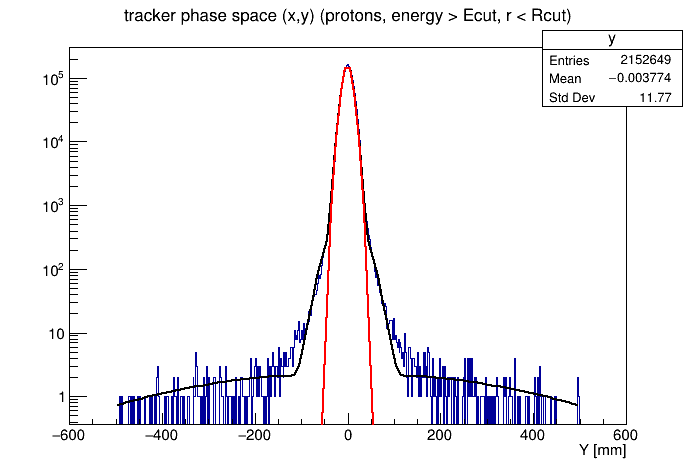

In [17]:
c1 = ROOT.TCanvas()
projY.Draw()
f2.SetLineColor(ROOT.kBlack)
f2.Draw('same')
f1.Draw('same')
projY.GetXaxis().SetRangeUser(-600,600)
c1.SetLogy()
c1.Draw()
print(f1_res)
print(f2_res)

In [18]:
#cc2 = ROOT.TCanvas()
#targ.Draw()
#cc2.Draw()

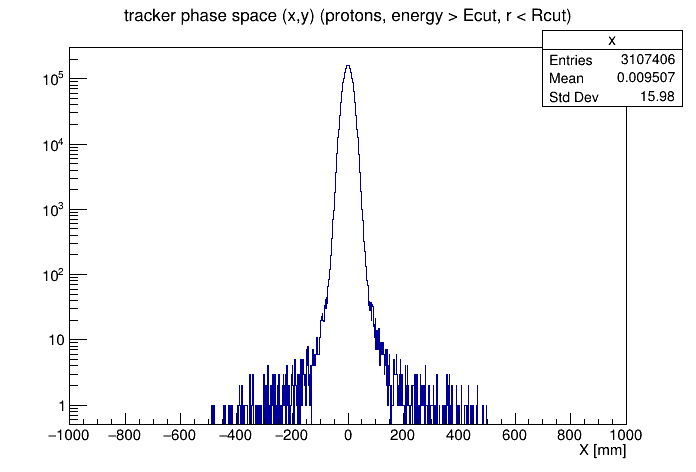

In [37]:
cc2 = ROOT.TCanvas()
#targX=targ.Clone()
projX = targ.ProjectionX("x",targ.GetYaxis().FindBin(-2),targ.GetYaxis().FindBin(2))
projX.Draw()
cc2.Draw()
cc2.SetLogy()

In [54]:
xmax=500
f1 = ROOT.TF1('f1','gaus',-xmax,xmax)
f1_res = projX.Fit(f1, 'RS')
print(f1_res)
p0 = f1.GetParameter(0)
p1 = f1.GetParameter(1)
p2 = f1.GetParameter(2)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      3561.42
NDf                       =          330
Edm                       =   2.1294e-07
NCalls                    =           64
Constant                  =       159056   +/-   112.418     
Mean                      =   0.00670935   +/-   0.00883772  
Sigma                     =        15.57   +/-   0.0065569    	 (limited)

 FCN=3561.42 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=2.1294e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.59056e+05   1.12418e+02   2.63082e+00   5.79810e-06
   2  Mean         6.70935e-03   8.83772e-03   2.57561e-04  -2.28650e-02
   3  Sigma        1.55700e+01   6.55690e-03   3.23865e-06   4.00902e-01


In [55]:
r=0.1
xmax=500
f2 = ROOT.TF1('f2','[0] * exp(-x*x/(2*[1]*[1])) + [2] * exp(-x*x/(2*[3]*[3])) + [4] * exp(-x*x/(2*[5]*[5])) + [6] * exp(-x*x/(2*[7]*[7]))',-xmax,xmax)
print(type(r))
f2.SetParameters(p0*(1-r),p2,p0*r,20,p0*(1-r*r),p2,p0*(1-r*r*r),p2*10)

print(f1.GetParameter(0),f2.GetParameter(0), f2.GetParameter(1),p0,p1,p2)

<class 'float'>
159056.04407954967 143150.4396715947 15.570046717592556 159056.04407954967 0.0067093457619991186 15.570046717592556


In [58]:
f2.SetParLimits(0,p0*0.5,p0*2)
f2.SetParLimits(2,0.1,p0*0.5)
x1=3
x2=20
f2.SetParLimits(1,p2*0.1,p2*5)
f2.SetParLimits(3,p2*1.01,p2*x1)
f2.SetParLimits(4,0.1,p0)
f2.SetParLimits(5,p2*(x1+0.1),p2*x2)
f2.SetParLimits(6,0.1,p0)
f2.SetParLimits(7,p2*(x2+0.1),p2*x2*20)
f2_res = projX.Fit(f2, 'RS')
#print(f1_res)
#print(f2_res)

 FCN=298.513 FROM MIGRAD    STATUS=CONVERGED     949 CALLS         950 TOTAL
                     EDM=6.86816e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   0.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.58598e+05   1.14113e+02  -6.66305e-08   5.39531e-01
   2  p1          -1.53512e+01   8.80919e-03   5.98626e-06   4.04220e-02
   3  p2           1.51684e+03   5.36023e+01  -1.85329e-02  -4.46131e-06
   4  p3           2.73447e+01   1.82136e-04  -1.59963e-08   3.28757e+02
   5  p4           5.22820e+01   4.98193e+00   4.92653e-07   1.01383e+00
   6  p5           4.82671e+01   3.70245e-08  -4.42974e-11** at limit **
   7  p6           2.12330e+00   1.25861e-01  -2.58804e-07  -1.73093e+01
   8  p7           3.12958e+02   6.01014e-07  -2.10998e-11** at limit **


Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 



****************************************
Minimizer is Minuit / Migrad
Chi2                      =      3561.42
NDf                       =          330
Edm                       =   2.1294e-07
NCalls                    =           64
Constant                  =       159056   +/-   112.418     
Mean                      =   0.00670935   +/-   0.00883772  
Sigma                     =        15.57   +/-   0.0065569    	 (limited)


****************************************
         Invalid FitResult  (status = 4 )
****************************************
Minimizer is Minuit / Migrad
Chi2                      =  4.34182e+09
NDf                       =          325
Edm                       =  3.87595e+09
NCalls                    =          302
p0                        =       318102   +/-   147349       	 (limited)
p1                        =     -14.0423   +/-   1           
p2                        =  1.09809e+06   +/-   8.18524     
p3                        =      37.7481   +/-   1

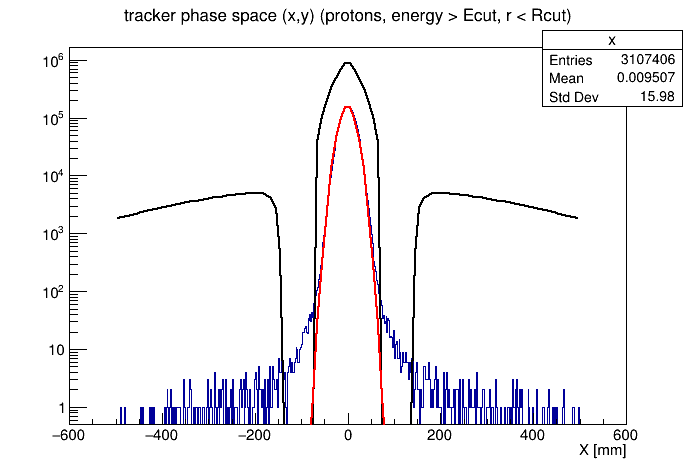

In [57]:
c1 = ROOT.TCanvas()
projX.Draw()
f2.SetLineColor(ROOT.kBlack)
f2.Draw('same')
f1.Draw('same')
projX.GetXaxis().SetRangeUser(-600,600)
c1.SetLogy()
c1.Draw()
print(f1_res)
print(f2_res)

In [24]:
1/(f2.GetParameter(2)*ROOT.sqrt(6.28))

3.6339827066394636e-07

In [25]:
Gdata = projY.GetIntegral()
#c1 = ROOT.TCanvas()

#c1.Draw()


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      3561.42
NDf                       =          330
Edm                       =   2.1294e-07
NCalls                    =           64
Constant                  =       159056   +/-   112.418     
Mean                      =   0.00670935   +/-   0.00883772  
Sigma                     =        15.57   +/-   0.0065569    	 (limited)


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      690.229
NDf                       =          325
Edm                       =  3.10292e-08
NCalls                    =          623
p0                        =       159329   +/-   112.646      	 (limited)
p1                        =      15.4733   +/-   0.00693547  
p2                        =      1247.91   +/-   61.9048     
p3                        =      46.1687   +/-   0.000247086  	 (limited)
p4                        =     -925.819   +/-   53.5502   

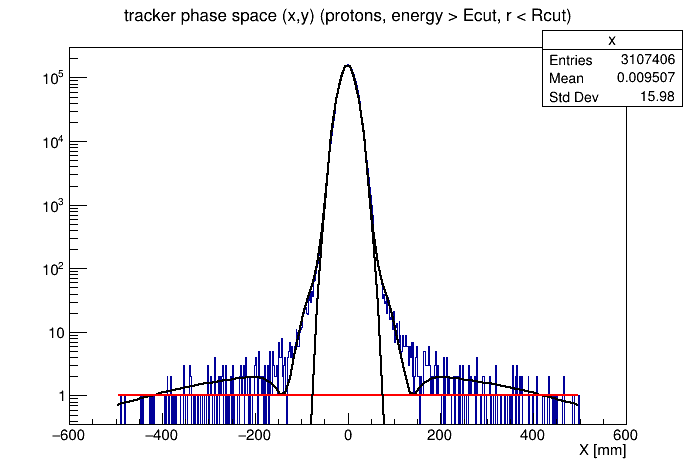

In [26]:
projX = targ.ProjectionX("x",targ.GetYaxis().FindBin(-2),targ.GetYaxis().FindBin(2))
f3 = ROOT.TF1("f3","1/ pow(x,[0])",-xmax,xmax)
f3_res = projX.Fit(f2, 'RS')
c1 = ROOT.TCanvas()
projX.Draw()
f1.SetLineColor(ROOT.kBlack)
f3.Draw('same')
f1.Draw('same')
projX.GetXaxis().SetRangeUser(-600,600)
c1.SetLogy()
c1.Draw()
print(f1_res)
print(f3_res)